# Neccesary Imports

In [4]:
# !pip install nltk

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

Let's read the data from csv file

In [5]:
sms = pd.read_csv('spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [6]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [4]:
sms.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's create new feature "message length" and plot it to see if it's of any interest

In [7]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

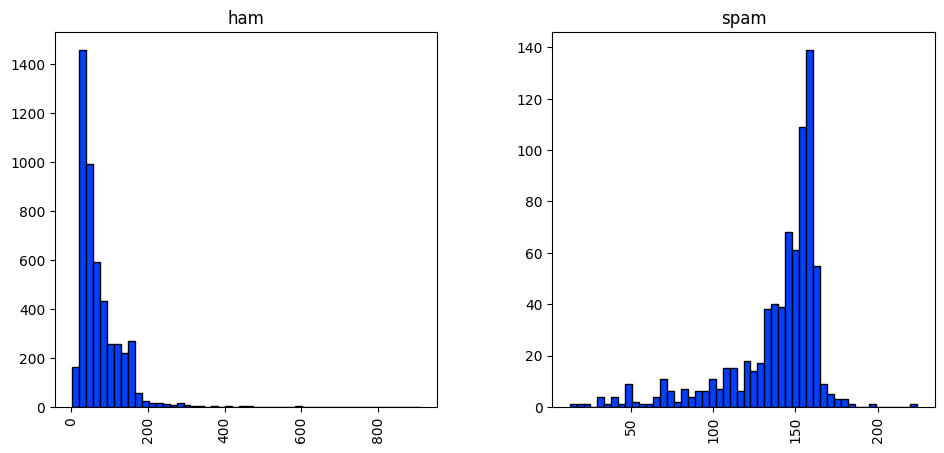

In [8]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [9]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [10]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [11]:
text_feat = text_feat.apply(text_process)

In [13]:
vectorizer = TfidfVectorizer()

In [14]:
features = vectorizer.fit_transform(text_feat)

###  Classifiers and predictions

First of all let's split our features to test and train set

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [17]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Parametres are based on notebook:
[Spam detection Classifiers hyperparameter tuning][1]


  [1]: https://www.kaggle.com/muzzzdy/d/uciml/sms-spam-collection-dataset/spam-detection-classifiers-hyperparameter-tuning/

In [18]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [19]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [20]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [39]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))

In [40]:
# df = pd.DataFrame(pred_scores, columns=['Score'])
# df
pred_scores
df = pd.DataFrame(pred_scores,columns=['model','Score'])
df

,model,Score
0,SVC,0.978469
1,KN,0.924641
2,NB,0.984450
3,DT,0.958732
4,LR,0.943182
5,RF,0.970096
6,AdaBoost,0.967105
7,BgC,0.966507
8,ETC,0.977273


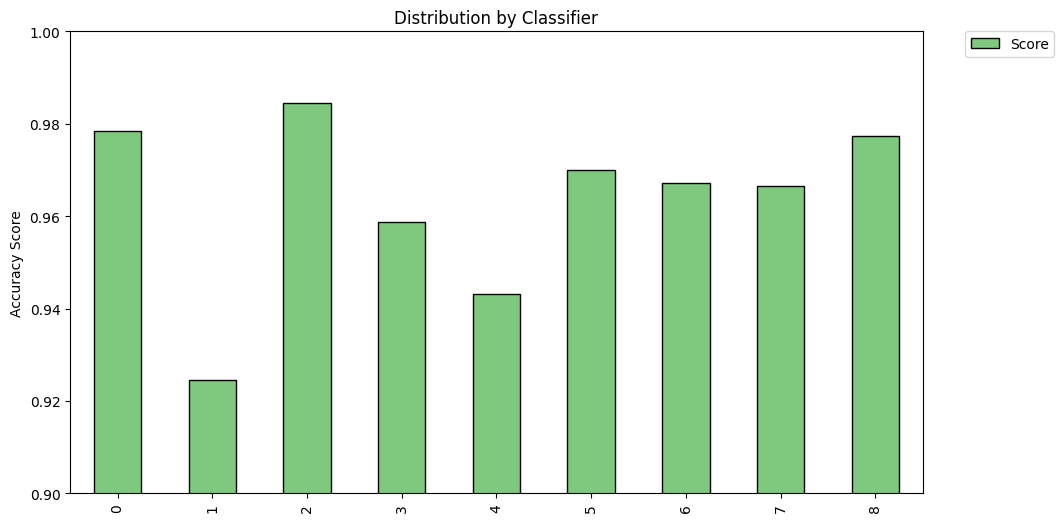

In [41]:
df['Score'].plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like ensemble classifiers are not doing as good as expected.

### Stemmer

It is said that stemming short messages does no goot or even harm predictions. Let's try this out.

Define our stemmer function

In [42]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

Stem, split, fit - repeat... Predict!

In [43]:
text_feat = text_feat.apply(stemmer)

In [44]:
features = vectorizer.fit_transform(text_feat)

In [45]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [49]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))

In [51]:
df2 = pd.DataFrame(pred_scores, columns=['model','Score2'])
df = pd.concat([df,df2],axis=1)
df

,model,Score,model,Score2
0,SVC,0.978469,SVC,0.978469
1,KN,0.924641,KN,0.927632
2,NB,0.984450,NB,0.985048
3,DT,0.958732,DT,0.959928
4,LR,0.943182,LR,0.946770
5,RF,0.970096,RF,0.974880
6,AdaBoost,0.967105,AdaBoost,0.970096
7,BgC,0.966507,BgC,0.968900
8,ETC,0.977273,ETC,0.977871


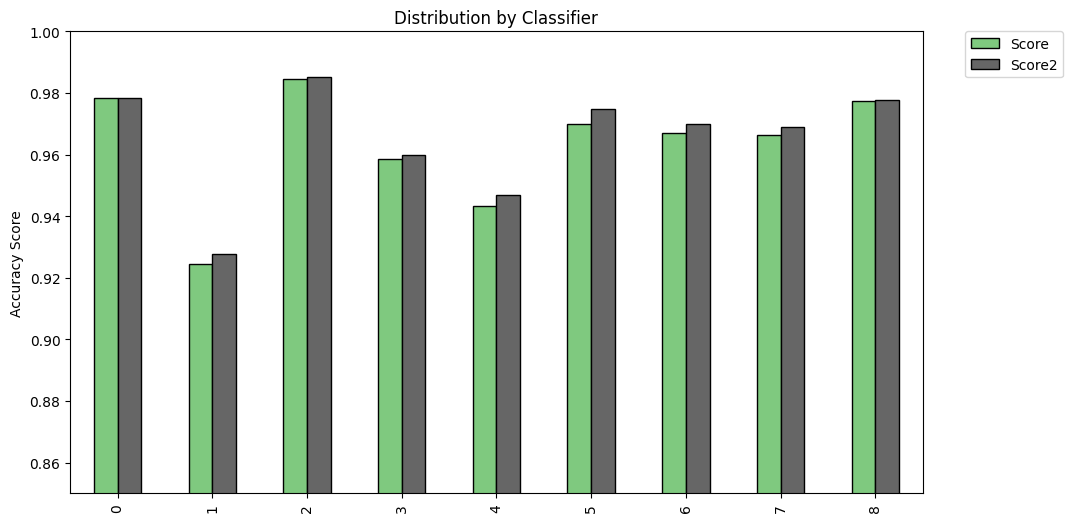

In [52]:
df[['Score','Score2']].plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like mostly the same . Ensemble classifiers doing a little bit better, NB still got the lead.

### What have we forgotten? Message length!

Let's append our message length feature to the matrix we fit into our classifiers

In [57]:
lf = sms['length'].to_numpy()
newfeat = np.hstack((features.todense(),lf[:, None]))

In [59]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, sms['label'], test_size=0.3, random_state=111)

In [61]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))

C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please 

In [65]:
df3 = pd.DataFrame(pred_scores, columns=['model','Score3'])
df = pd.concat([df3['model'],df[['Score','Score2']],df3['Score3']],axis=1)
df

,model,Score,Score2,Score3
0,SVC,0.978469,0.978469,0.861244
1,KN,0.924641,0.927632,0.882775
2,NB,0.984450,0.985048,0.982656
3,DT,0.958732,0.959928,0.957536
4,LR,0.943182,0.946770,0.954545
5,RF,0.970096,0.974880,0.975478
6,AdaBoost,0.967105,0.970096,0.961722
7,BgC,0.966507,0.968900,0.966507
8,ETC,0.977273,0.977871,0.975478


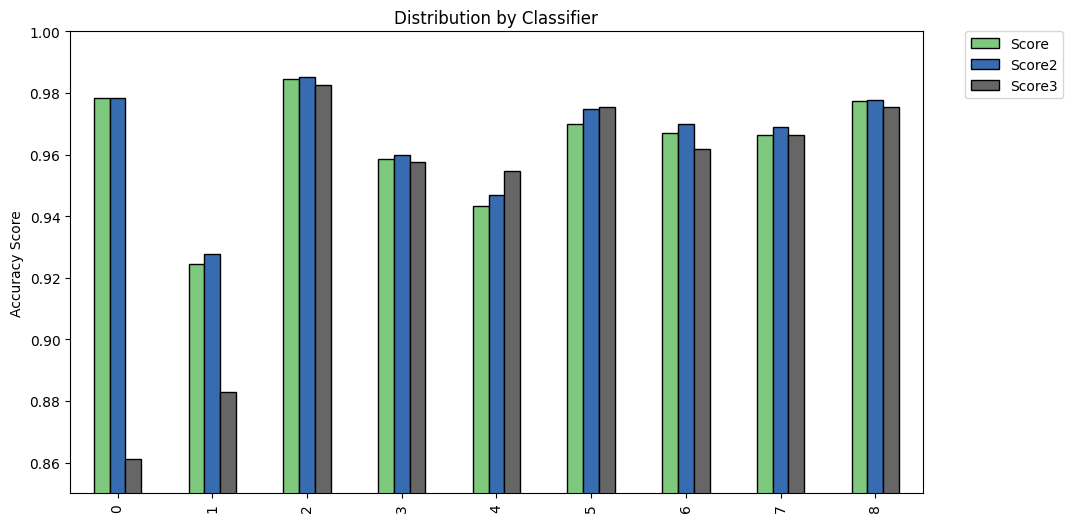

In [66]:
df.drop('model',axis=1).plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This time everyone are doing a little bit worse, except for LinearRegression and RandomForest. But the winner is still MultinominalNaiveBayes.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [67]:
from sklearn.ensemble import VotingClassifier

In [68]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [69]:
eclf.fit(features_train,labels_train)

C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please 

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(n_estimators=9,
                                                random_state=111)),
                             ('ETC',
                              ExtraTreesClassifier(n_estimators=9,
                                                   random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=31,
                                                     random_state=111)),
                             ('Ada',
                              AdaBoostClassifier(n_estimators=62,
                                                 random_state=111))],
                 voting='soft')

In [70]:
pred = eclf.predict(features_test)

C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please 

In [71]:
print(accuracy_score(labels_test,pred))

0.979066985645933


###  NaiveBayes is our best model in spam detection.

## Saving Model file 

In [72]:
import joblib

In [73]:
joblib.dump(eclf, 'model.joblib')

['model.joblib']

## Calling model file using joblib

In [74]:
model_test = joblib.load('model.joblib')

In [75]:
model_test.predict(features_test)

C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\World of wonders\Desktop\Bharat_intern_projecs\Task-3_Cat_dog_classifier\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please 

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)